# Transfer Learning with Pytorch

Transfer learning is a machine learning technique where a pre-trained model, which has been trained on a large dataset for a specific task, is repurposed as the starting point for training a new model on a different but related task.

Transfer learning offers several advantages:
- **Faster Training**
- **Better Performance**
- **Feature Extraction**
- **Domain Adaptation**

PyTorch is a popular deep learning framework that is well-suited for transfer learning, and here's why you might choose to use PyTorch for this purpose:
- **Dynamic Computation Graph**
- **Large Pre-trained Model Collection**
- **Flexible and Intuitive API**
- **Active Research Community**

In summary, transfer learning is a powerful technique for leveraging pre-trained models to solve new tasks, and PyTorch's dynamic nature, pre-trained model collection, and ease of use make it a suitable choice for implementing transfer learning workflows.

## About Dataset

**Food Image Classification Dataset**
- The dataset contains **19K** unique images obtained from various Google resources
- Focuses on **17 varieties** of Western appetizers
- Meticulously curated images ensuring diversity and representativeness
- Provides a solid foundation for developing robust and precise image classification algorithms
- Encourages exploration in the fascinating field of food image classification

## Import Library

In [117]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import os
import torchvision
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

## Load Data

In [52]:
INPUT_PATH = 'data'
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
VALIDATION_PATH = 'data/val'
CLASS_NAMES = os.listdir('data/train')
CLASS_NAMES.sort()

In [53]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       normalize])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       normalize])

image_datasets = {
    'train': datasets.ImageFolder(TRAIN_PATH, train_transforms),
    'validation': datasets.ImageFolder(VALIDATION_PATH, test_transforms),
    'test' : datasets.ImageFolder(TEST_PATH, test_transforms)
}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64,shuffle=True)
val_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64,shuffle=False)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64,shuffle=False)

## Inspect Data

### Data Count

In [54]:
# Train Count
print("Data Count")
print("----------")
print(f"Training total   : {len(train_loader.dataset)}")
print(f"Validation total : {len(val_loader.dataset)}")
print(f"Testing total    : {len(test_loader.dataset)}")

Data Count
----------
Training total   : 6922
Validation total : 864
Testing total    : 868


### Images Preview

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


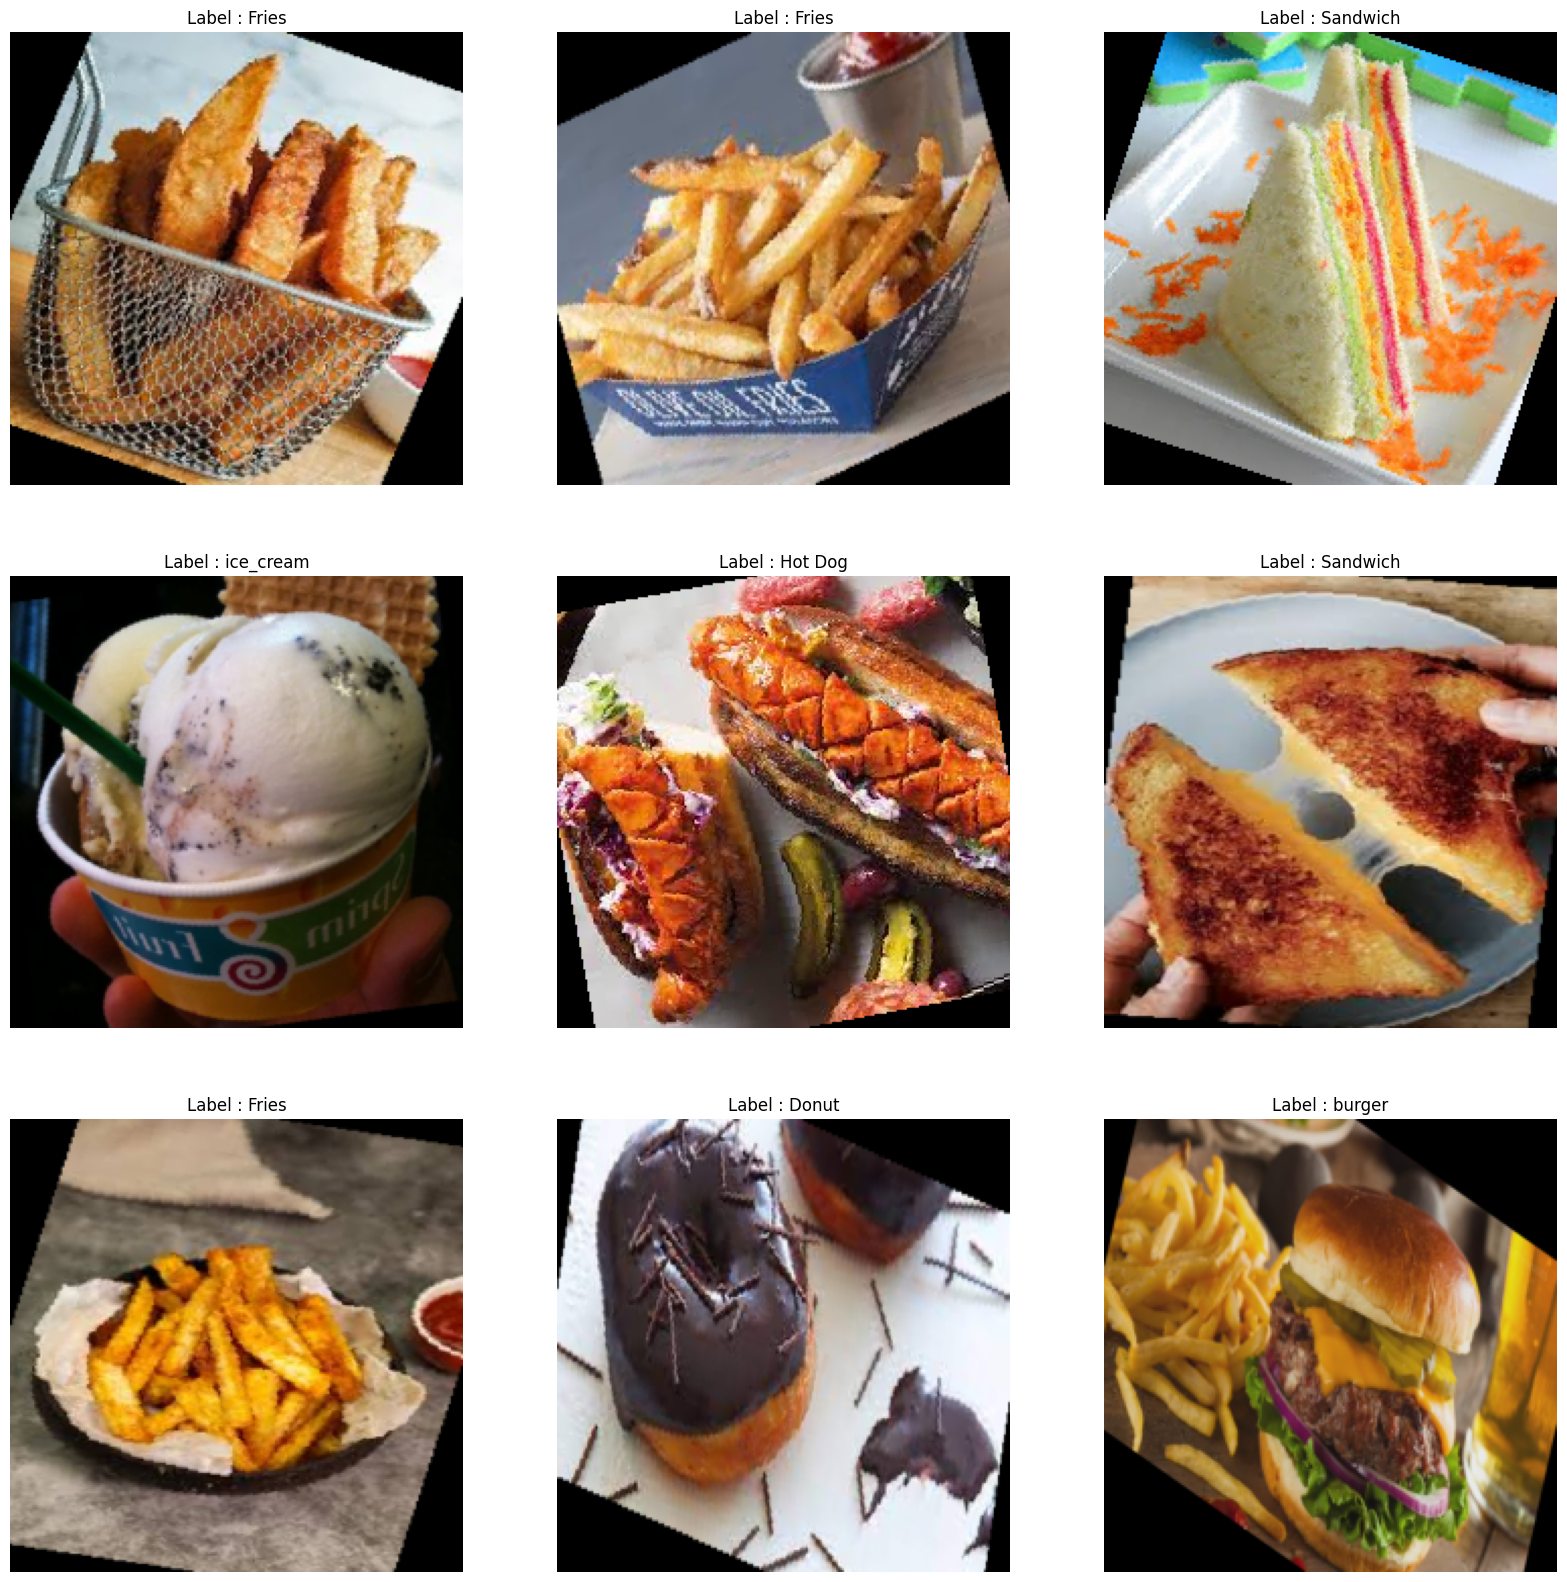

In [55]:
img, label = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].permute(1, 2, 0).numpy() * std + mean)
    plt.title(f'Label : {CLASS_NAMES[label[i]]}')
    plt.axis('off')

## Create Model

In [56]:
# Download resnet18
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Freeze all the layers bar the last one
for param in model_resnet18.parameters():
    param.requires_grad = False

model_resnet18.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8))

In [87]:
# Download vgg16
model_vgg16 = torchvision.models.vgg16(pretrained=True)

# Freeze all the layers bar the last one
for param in model_vgg16.parameters():
    param.requires_grad = False

# Newly created modules have require_grad=True by default
num_features = model_vgg16.classifier[6].in_features
features = list(model_vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features,8)]) # Add our layer with 4 outputs
model_vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

In [107]:
# Download efficientNetB3
model_efficientnetB3 = torchvision.models.efficientnet_b3(pretrained=True)

# Freeze all the layers bar the last one
for param in model_efficientnetB3.parameters():
    param.requires_grad = False

model_efficientnetB3_fc= nn.Sequential(
               nn.Linear(1536, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 8))

model_efficientnetB3.classifier = model_efficientnetB3_fc

## Train Model

In [88]:
def train_model(model):
    # Declaring Criterion and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    since = time.time()
    epochs = 5
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for e in range(epochs):
        running_time = time.time()
        running_loss = 0.0
        total = 0
        correct = 0

        model.train(True)

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            
            
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs,labels)
            
            loss.backward()
            
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            train_acc.append(accuracy)

            running_loss += loss.item()
            train_loss.append(running_loss)

        model.eval()
        total = 0
        correct = 0
        running_loss = 0.0   

        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            val_acc.append(accuracy)

            running_loss += loss.item()
            val_loss.append(running_loss)

        elapsed_running_time = time.time() - running_time
        print()
        print("Epoch {}/{}".format(e+1,epochs))
        print(f'{round(elapsed_running_time,2)}s - loss : {train_loss[e]} - accuracy : {train_acc[e]} - val loss : {val_loss[e]} - val acc {val_acc[e]}')
        
    
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

    return {
        "train_loss" : train_loss,
        "train_acc"  : train_acc,
        "val_loss"   : val_loss,
        "val_acc"    : val_acc,
        "model"      : model
    }

**Resnet Model**

In [62]:
resnet18_result = train_model(model_resnet18)


Epoch 1/5
355.65s - loss : 0.6720278263092041 - accuracy : 79.6875 - val loss : 0.33970901370048523 - val acc 89.0625

Epoch 2/5
358.87s - loss : 1.9667866230010986 - accuracy : 71.09375 - val loss : 0.63078773021698 - val acc 89.0625

Epoch 3/5
362.9s - loss : 2.578604817390442 - accuracy : 73.95833333333333 - val loss : 1.35686856508255 - val acc 85.41666666666667

Epoch 4/5
363.05s - loss : 3.1025959849357605 - accuracy : 75.0 - val loss : 1.988589346408844 - val acc 82.8125

Epoch 5/5
366.17s - loss : 3.532067060470581 - accuracy : 77.5 - val loss : 2.586851179599762 - val acc 82.5

Training completed in 30m 7s


**VGG16 Model**

In [89]:
vgg16_result = train_model(model_vgg16)


Epoch 1/5
1730.74s - loss : 2.267855644226074 - accuracy : 9.375 - val loss : 0.1373549997806549 - val acc 95.3125

Epoch 2/5
1728.8s - loss : 5.940446853637695 - accuracy : 20.3125 - val loss : 0.23938769847154617 - val acc 95.3125

Epoch 3/5
1771.24s - loss : 7.671242356300354 - accuracy : 32.291666666666664 - val loss : 0.685970313847065 - val acc 92.1875

Epoch 4/5
1682.17s - loss : 9.114068388938904 - accuracy : 40.625 - val loss : 1.1282673850655556 - val acc 91.40625

Epoch 5/5
1744.84s - loss : 10.631152033805847 - accuracy : 45.3125 - val loss : 1.8237982168793678 - val acc 89.6875

Training completed in 144m 18s


**EfficientNetB3 Model**

In [108]:
efficientnetB3_result = train_model(model_efficientnetB3)


Epoch 1/5
1219.73s - loss : 2.07370924949646 - accuracy : 14.0625 - val loss : 0.2347516268491745 - val acc 89.0625

Epoch 2/5
1209.04s - loss : 3.891297936439514 - accuracy : 21.09375 - val loss : 0.5125452131032944 - val acc 89.84375

Epoch 3/5
1225.47s - loss : 5.474738955497742 - accuracy : 27.604166666666668 - val loss : 0.8452590852975845 - val acc 88.54166666666667

Epoch 4/5
1235.2s - loss : 7.13593590259552 - accuracy : 34.375 - val loss : 1.1001879125833511 - val acc 89.0625

Epoch 5/5
1215.09s - loss : 8.302743673324585 - accuracy : 39.0625 - val loss : 1.5073217302560806 - val acc 88.75

Training completed in 101m 45s


### Compare Model

In [ ]:
avg_val_resnet = np.mean(resnet18_result['val_acc'])
avg_val_result = np.mean(vgg16_result['val_acc'])
avg_efficientnetB3_result = np.mean(efficientnetB3_result['val_acc'])

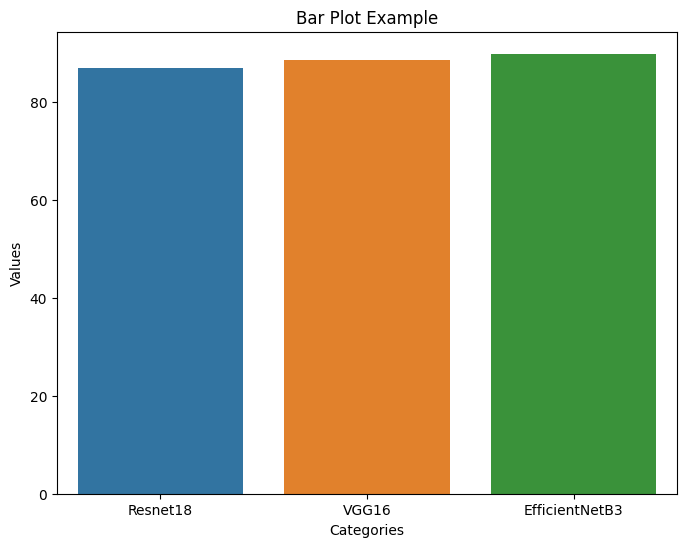

In [127]:
val_result = np.array([avg_val_resnet,vgg16_result,efficientnetB3_result])
model_names = ['Resnet18', 'VGG16', 'EfficientNetB3']

plt.figure(figsize=(8, 6))
sns.barplot(x=model_names,y=val_result)

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Values")
plt.title("Bar Plot Example")

# Show the plot
plt.show()